In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps1 = rand(d, n);
eps2 = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = (sin.(features*[1, -1, 0, 0, 0, 0, 0, 0, 0, 0])+eps1).*T  + cos.(features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0])+eps2;


In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0   0.802884
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0   0.604157
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0  -0.258986
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0   1.57154
 2.53849   5.30423   5.84012       0.570453   9.6668    1.0   1.1786
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0   2.35943
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0   0.180733
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0   2.13882
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0  -1.71446
 1.25287   6.88003   3.64868       4.16181    3.00126   1.0   2.82832
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0   0.908347
 1.36551   1.07227   0.570038      2.53062    7.60498   0.0  -0.810145
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0  -0.481874
 ⋮                              ⋱                       ⋮ 

In [4]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_8.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = sin.(Xtest_1[:, 1]-Xtest_1[:, 2]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1]-Xtest[:, 2])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.5474166264627512
5.503944727612992e-5


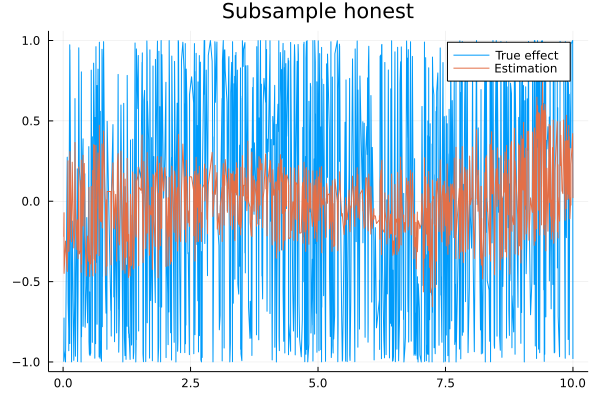

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [9]:
get_freq(cf, 3)

Dict{Any, Float64} with 10 entries:
  5  => 0.0749923
  4  => 0.0541781
  6  => 0.0584634
  7  => 0.0590756
  2  => 0.267524
  10 => 0.0511172
  9  => 0.0633609
  8  => 0.0722375
  3  => 0.0523416
  1  => 0.24671

In [10]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0851756
  4  => 0.0740294
  6  => 0.0741222
  7  => 0.0790451
  2  => 0.186513
  10 => 0.0699424
  9  => 0.0768159
  8  => 0.0774661
  3  => 0.0739365
  1  => 0.202954

In [11]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0932969
  4  => 0.0943905
  6  => 0.0912605
  7  => 0.0910154
  2  => 0.134986
  10 => 0.0851702
  9  => 0.0884322
  8  => 0.0903743
  3  => 0.0885264
  1  => 0.142547

### Bootstrap

In [12]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1]-Xtest[:, 2])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

0.6039793673624677
5.999411171857961e-5


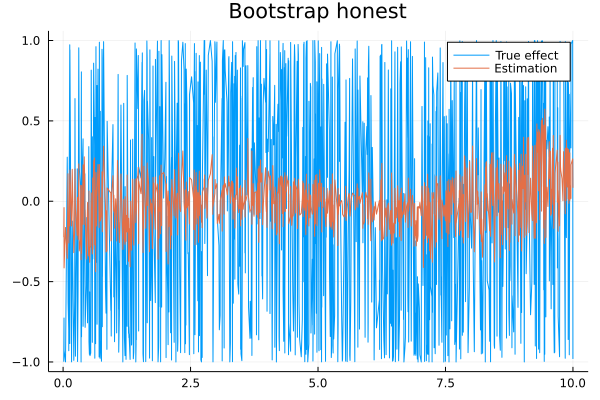

In [13]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [14]:
get_freq(cf, 3)

Dict{Any, Float64} with 10 entries:
  5  => 0.0911901
  4  => 0.0723338
  6  => 0.0658423
  7  => 0.0809892
  2  => 0.193818
  10 => 0.0720247
  9  => 0.0788253
  8  => 0.0720247
  3  => 0.0748068
  1  => 0.198145

In [15]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0928551
  4  => 0.0874096
  6  => 0.0797108
  7  => 0.0892874
  2  => 0.156793
  10 => 0.0828091
  9  => 0.0866585
  8  => 0.085438
  3  => 0.0844052
  1  => 0.154633

In [16]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0974351
  4  => 0.0972192
  6  => 0.0931542
  7  => 0.0950068
  2  => 0.119127
  10 => 0.0930463
  9  => 0.093442
  8  => 0.0925966
  3  => 0.0936938
  1  => 0.125279